In [1]:
import boto3
import geopandas as gpd
import pandas as pd
import folium
import numpy as np
from folium import GeoJson
from io import BytesIO

In [2]:
import sys
sys.path.append("/agrilearn_app/agrilearn/")
from agrilearn.utils import s3_utils, str_utils

### Global Variables

In [3]:
GEOPACKAGE_PATH = f"/agrilearn_app/datasets/teste_pre_safra_2024_2025/geopackage/processed/data_merged_crop_120_06_08_2024_input_mvp_processing.gpkg"

# 1. Read Datasets

In [4]:
# df_train = gpd.read_file(DATASET_PATH_TRAIN)
# df_val = gpd.read_file(DATASET_PATH_VAL)
# df_test = gpd.read_file(DATASET_PATH_TEST)

# df_train['dataset_part'] = 'train'
# df_val['dataset_part'] = 'val'
# df_test['dataset_part'] =  'test'

# df = pd.concat([df_train, df_val, df_test])

gdf = gpd.read_file(GEOPACKAGE_PATH)

gdf['dataset_part'] = 'test'

In [5]:
gdf['dataset_part'].value_counts()

dataset_part
test    8360
Name: count, dtype: int64

In [6]:
gdf['monitoring_class'].value_counts()

monitoring_class
SOYBEAN    8233
CORN        127
Name: count, dtype: int64

In [12]:
gdf['gt_class'].value_counts()

gt_class
SOYBEAN       7283
CORN           579
COTTON         267
RICE            81
PASTURE         50
SUGAR_CANE      50
WHEAT           50
Name: count, dtype: int64

In [14]:
gdf['state'].value_counts()

state
RS    1550
GO    1397
MT    1358
SP     854
MS     839
PR     491
BA     450
MG     414
TO     334
PA     210
PI     152
MA     151
RO      63
SC      62
RR      22
DF       6
AP       6
AC       1
Name: count, dtype: int64

In [15]:
print(f"There are {gdf.shape[0]} rows and {gdf.shape[1]} columns")

There are 8360 rows and 75 columns


In [16]:
print(f"Dados de {gdf['start_season'].min()} a {gdf['end_season'].max()}")

Dados de 2017-09-01 a 2024-09-01


In [18]:
list(gdf.columns)

['interest_area_id',
 'period',
 'start_season',
 'no_till_farming',
 'emergence_date',
 'emergence_sensor',
 'gt_class',
 'senescence_date',
 'senescence_sensor',
 'harvest_date',
 'harvest_sensor',
 'end_season',
 'area_ha',
 'created_at',
 'modified_by',
 'modified_at',
 'zarc_planting',
 'zarc_emergence',
 'interest_area_code',
 'monitoring_class',
 'state',
 'peak_start',
 'peak_end',
 'sentinel_eopatch_current',
 'field_id',
 'contour_selected_timestamp',
 'contour_score',
 'obs_contour',
 'obs_contour_score',
 'agricultural_area',
 'score_farm_plot',
 'obs_farm_plot',
 'field_confidence',
 'field_score',
 'emergence_score',
 'obs_emergence',
 'center_x',
 'center_y',
 'crop_valid_cls',
 'senescence_peak_date',
 'obs_senescence',
 'harvest_confidence',
 'harvest_score',
 'obs_harvest',
 'obs_extra',
 'created_by',
 'area_id',
 'last_date_crop_rnn',
 'crop_distance_score_sits',
 'crop_confidence_maha_sits',
 'id',
 'set',
 'fonte',
 'cultura_2',
 'area',
 'meso',
 'eopath_location

In [ ]:
gdf['dataset_part'].value_counts(normalize=True)*100

dataset_part
test    100.0
Name: proportion, dtype: float64

In [20]:
gdf.to_file(GEOPACKAGE_PATH,
           driver='GPKG', 
           engine='fiona')

# 2. Data Understading

### 2.1 Data description
- monitoring_class:** é a cultura de interesse dp cliente ou da amostra de treinamento (SOYBEAN, CORN)
- period:  a safra agricola (2023/2024, 2024/2025)
- state: é o estado do polígono
- field_id: id do talhão
- fonte: a origem dos dados (mapas temáticos, banco de dados)
- area:
- micro:
- start_season: é a data que inicia a safra pra determinada cultura (monitoring_class) e safra (period)
- end_season: é a data que termina a safra pra determinada cultura (monitoring_class) e safra (period)
- peak_start: é a data que inicia o período em que pode ocorrer o pico pra determinada cultura (monitoring_class) e safra (period)
- peak_end: é a data que termina o período em que pode ocorrer o pico pra determinada cultura (monitoring_class) e safra (period) (Obs: temos um calendário pra isso, um arquivo yaml)
- start_of_cycle: data do inio do cultivo segundo o calendário agrícola
- end_of_cycle: data do fim do caledário de cuiltivo segundo calendário agrícola
- length_of_cycle:
- start_of_season: data da emergencia da cultura
- end_of_season: data da colheita da cultura
- peak_of_season: data do pico vegetativo da cultura
- length_of_season: Duração do cultivo
- eopath_location: é caminho onde o eopatch está salvo (imagens p/ inferência)
- geometry: é a geometria do polígono]

# 3. Data Processing

### 3.1 Check the Data formatation

In [21]:
gdf.isna().sum()

interest_area_id       0
period                 0
start_season           0
no_till_farming     8350
emergence_date        71
                    ... 
uf                  8017
uuid                8017
peak_date           8112
geometry               0
dataset_part           0
Length: 75, dtype: int64

### 3.2 Vamos manter os dados nulos no campo ``contour_score``

In [22]:
gdf[df['contour_score'].isna()]

NameError: name 'df' is not defined

In [15]:
df[df['contour_score'].isna()].shape[0] / df.shape[0]

0.051678194806667424

In [16]:
df[df['contour_score'].isna()]['monitoring_class'].value_counts()

monitoring_class
SUGAR_CANE    1823
Name: count, dtype: int64

### 3.3 Data Formatation

In [17]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 35276 entries, 0 to 1590
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   monitoring_class            35276 non-null  object  
 1   period                      35276 non-null  object  
 2   fonte                       35276 non-null  object  
 3   cultura_2                   35276 non-null  object  
 4   state                       35276 non-null  object  
 5   area                        35276 non-null  float64 
 6   meso                        35276 non-null  int64   
 7   obs_extra                   35276 non-null  object  
 8   eopath_location             35276 non-null  object  
 9   start_season                35276 non-null  object  
 10  end_season                  35276 non-null  object  
 11  peak_start                  35276 non-null  object  
 12  peak_end                    35276 non-null  object  
 13  sentinel_eopat

### 3.3.1 Datetime variables

In [23]:
datetime_columns = ['start_season', 
                    'end_season', 
                    'peak_start', 
                    'peak_end']

gdf[datetime_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8360 entries, 0 to 8359
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   start_season  8360 non-null   object
 1   end_season    8360 non-null   object
 2   peak_start    8360 non-null   object
 3   peak_end      8360 non-null   object
dtypes: object(4)
memory usage: 261.4+ KB


In [25]:
for col in datetime_columns:
    print(col)
    gdf[col] = pd.to_datetime(gdf[col])

start_season
end_season
peak_start
peak_end


#### 3.3.2 Integer variables

In [26]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 8360 entries, 0 to 8359
Data columns (total 75 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   interest_area_id            8360 non-null   int64         
 1   period                      8360 non-null   object        
 2   start_season                8360 non-null   datetime64[ns]
 3   no_till_farming             10 non-null     object        
 4   emergence_date              8289 non-null   object        
 5   emergence_sensor            6265 non-null   object        
 6   gt_class                    8360 non-null   object        
 7   senescence_date             5909 non-null   object        
 8   senescence_sensor           5981 non-null   object        
 9   harvest_date                4616 non-null   object        
 10  harvest_sensor              4673 non-null   object        
 11  end_season                  8360 non-null   date

# 4. Data Analysis

### 4.1 Analysing Target y (monitoring_class)

In [27]:
pd.concat([gdf['monitoring_class'].value_counts(),
          gdf['monitoring_class'].value_counts(normalize=True)*100], axis=1)

,count,proportion
monitoring_class,,
SOYBEAN,8233,98.480861
CORN,127,1.519139


In [29]:
pd.concat([gdf['gt_class'].value_counts(),
          gdf['gt_class'].value_counts(normalize=True)*100], axis=1)

,count,proportion
gt_class,,
SOYBEAN,7283,87.117225
CORN,579,6.925837
COTTON,267,3.193780
RICE,81,0.968900
PASTURE,50,0.598086
SUGAR_CANE,50,0.598086
WHEAT,50,0.598086


### 4.2 Analysing fonte de dados

In [28]:
pd.concat([gdf['fonte'].value_counts(), gdf['fonte'].value_counts(normalize=True)*100], axis=1)

,count,proportion
fonte,,
Agrosatélite - Grãos Brasil 2021/2022,1013,49.535452
Agrosatélite - Grãos Brasil 2020/2021,970,47.432763
Conab - Arroz Irrigado 2019/2020,28,1.369193
Conab - Arroz Irrigado 2018/2019,24,1.173594
Conab - Arroz Irrigado 2017/2018,8,0.391198
Conab - Arroz Irrigado 2021/2022,2,0.097800


### 4.3 Analysing dados por estado

In [30]:
pd.concat([gdf['state'].value_counts(),
          gdf['state'].value_counts(normalize=True)*100], axis=1)

,count,proportion
state,,
RS,1550,18.540670
GO,1397,16.710526
MT,1358,16.244019
SP,854,10.215311
MS,839,10.035885
PR,491,5.873206
BA,450,5.382775
MG,414,4.952153
TO,334,3.995215


### 4.6 Analysis field_id (existem IDs duplicados para os talhões)

In [31]:
gdf['field_id'].nunique()

1985

In [32]:
gdf[gdf.duplicated(['field_id','period'])]

,interest_area_id,period,start_season,no_till_farming,emergence_date,emergence_sensor,gt_class,senescence_date,senescence_sensor,harvest_date,...,start_of_season,end_of_season,peaks,length_of_season,progress_status,uf,uuid,peak_date,geometry,dataset_part
1,1,2023/2024,2023-10-01,None,2024-01-12,MSI / Sentinel 2,SOYBEAN,2024-03-04,MSI / Sentinel 2,None,...,NaT,NaT,None,None,None,None,None,None,"MULTIPOLYGON (((-49.87649 -17.50258, -49.88479...",test
2,2,2023/2024,2023-10-01,None,2023-12-06,OLI / Landsat 9,SOYBEAN,2024-02-24,OLI / Landsat 9,2024-03-05,...,NaT,NaT,None,None,None,None,None,None,"MULTIPOLYGON (((-48.5898 -4.8188, -48.58982 -4...",test
3,3,2023/2024,2023-10-01,None,2024-01-17,OLI / Landsat 8,SOYBEAN,2024-03-14,MSI / Sentinel 2,None,...,NaT,NaT,None,None,None,None,None,None,"MULTIPOLYGON (((-47.92268 -17.87173, -47.92267...",test
4,4,2023/2024,2023-10-01,None,2024-01-17,OLI / Landsat 8,SOYBEAN,2024-03-13,OLI / Landsat 9,None,...,NaT,NaT,None,None,None,None,None,None,"MULTIPOLYGON (((-47.92267 -17.87151, -47.92268...",test
5,5,2023/2024,2023-10-01,None,2024-02-21,MSI / Sentinel 2,SOYBEAN,None,None,None,...,NaT,NaT,None,None,None,None,None,None,"MULTIPOLYGON (((-53.76915 -28.96132, -53.76946...",test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8355,327,2023/2023,2023-02-01,None,2021-12-20,MSI / Sentinel 2,SUGAR_CANE,None,None,2022-11-29,...,NaT,NaT,None,None,ENCERRADO,SP,{02a0f996-ba82-4adc-a417-dd350e73756e},None,"MULTIPOLYGON (((-47.26655 -22.6615, -47.26652 ...",test
8356,328,2023/2023,2023-02-01,None,2021-11-25,MSI / Sentinel 2,SUGAR_CANE,None,None,2022-10-06,...,NaT,NaT,None,None,ENCERRADO,SP,{822ff516-1caf-4c13-9385-4e4461397674},None,"MULTIPOLYGON (((-47.25891 -22.61851, -47.25884...",test
8357,329,2023/2023,2023-02-01,None,2021-11-05,MSI / Sentinel 2,SUGAR_CANE,None,None,2022-11-25,...,NaT,NaT,None,None,ENCERRADO,SP,{d15c8fd1-24b8-4643-9543-7d1d99047797},None,"MULTIPOLYGON (((-47.24072 -22.66836, -47.24241...",test
8358,330,2023/2023,2023-02-01,None,2021-09-11,MSI / Sentinel 2,SUGAR_CANE,None,None,2022-11-05,...,NaT,NaT,None,None,ENCERRADO,SP,{2e14dc3f-9e78-4cd1-96e3-34e821c75683},None,"MULTIPOLYGON (((-47.23388 -22.64052, -47.235 -...",test


In [26]:
df[df.duplicated(['field_id','period'])]['field_id'].unique()

array(['0_5', '0_6', '0_7', '0_8', '0_10', '0_11', '0_12', '0_13', '0_14',
       '1_6', '1_7', '1_8', '1_9', '1_11', '1_12', '1_13', '1_14', '1_15',
       '1_17', '4_6', '4_8', '4_10', '4_11', '4_12', '4_13', '4_17',
       '4_20', '4_22', '4_26', '4_34', '5_3', '33_9', '54_5', '79_6',
       '79_9', '115_2', '119_6', '119_11', '155_1', '187_1', '200_7',
       '214_3', '230_2', '231_3', '252_4', '268_1', '268_5', '295_3',
       '305_0', '333_5', '335_5', '340_3', '366_1', '386_5', '417_2',
       '419_2', '419_7', '425_2', '428_2', '433_1', '444_5', '444_7',
       '444_8', '444_9', '444_12', '444_15', '444_20', '444_24', '444_25',
       '444_28', '444_29', '444_30', '470_1', '481_2', '481_4', '491_1',
       '533_1', '6_2', '6_3', '18_2', '20_2', '22_2', '23_1', '27_12',
       '29_1', '29_8', '40_1', '41_1', '41_3', '44_2', '46_2', '54_3',
       '55_6', '72_6', '72_7', '72_15', '72_25', '72_27', '72_28',
       '72_36', '72_39', '72_41', '72_47', '84_1', '89_5', '90_4', '91_4',

In [ ]:
#df[df['field_id'].isin(['0_6'])].to_csv('/agrilearn_app/datasets/cana-v1/csvs/duplicated_lines_CANA-sample-02.csv')

In [33]:
gdf[['cultura_2', 'monitoring_class']]

,cultura_2,monitoring_class
0,None,SOYBEAN
1,None,SOYBEAN
2,None,SOYBEAN
3,None,SOYBEAN
4,None,SOYBEAN
...,...,...
8355,None,CORN
8356,None,CORN
8357,None,CORN
8358,None,CORN


## 5. Generating Html Report

In [34]:
from ydata_profiling import ProfileReport
from ydata_profiling.config import Settings
%matplotlib inline

In [35]:
df_copy = gdf.drop(columns=['cultura_2', 'geometry'])  # Supondo que 'cultura_2' seja a coluna problemática

In [36]:
df_e_object = df_copy.select_dtypes(exclude=['object'])
df_e_object

,interest_area_id,start_season,end_season,created_at,modified_at,peak_start,peak_end,id,cycle_start,cycle_end,start_of_season,end_of_season
0,0,2023-10-01,2024-05-01,2023-09-29 21:02:29,2024-04-09 12:15:58,2023-12-01,2024-02-01,NaN,NaT,NaT,NaT,NaT
1,1,2023-10-01,2024-05-01,2023-11-18 02:06:12,2024-04-09 12:15:58,2023-12-01,2024-02-01,NaN,NaT,NaT,NaT,NaT
2,2,2023-10-01,2024-09-01,2023-09-27 03:37:49,2024-04-09 20:43:35,2023-12-01,2024-06-01,NaN,NaT,NaT,NaT,NaT
3,3,2023-10-01,2024-05-01,2023-10-10 15:42:24,2024-04-09 14:02:36,2023-12-01,2024-02-01,NaN,NaT,NaT,NaT,NaT
4,4,2023-10-01,2024-05-01,2023-10-10 15:42:24,2024-04-09 14:02:36,2023-12-01,2024-02-01,NaN,NaT,NaT,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...
8355,327,2023-02-01,2023-10-01,NaT,NaT,2023-04-01,2023-07-01,NaN,NaT,NaT,NaT,NaT
8356,328,2023-02-01,2023-10-01,NaT,NaT,2023-04-01,2023-07-01,NaN,NaT,NaT,NaT,NaT
8357,329,2023-02-01,2023-10-01,NaT,NaT,2023-04-01,2023-07-01,NaN,NaT,NaT,NaT,NaT
8358,330,2023-02-01,2023-10-01,NaT,NaT,2023-04-01,2023-07-01,NaN,NaT,NaT,NaT,NaT


In [37]:
df_i_object = df_copy.select_dtypes(include=['object'])
df_i_object

,period,no_till_farming,emergence_date,emergence_sensor,gt_class,senescence_date,senescence_sensor,harvest_date,harvest_sensor,area_ha,...,LOS,is_valid,is_valid_cvt,peaks,length_of_season,progress_status,uf,uuid,peak_date,dataset_part
0,2023/2024,None,2024-01-12,MSI / Sentinel 2,SOYBEAN,2024-03-04,MSI / Sentinel 2,None,None,9.41365563996948,...,None,None,None,None,None,None,None,None,None,test
1,2023/2024,None,2024-01-12,MSI / Sentinel 2,SOYBEAN,2024-03-04,MSI / Sentinel 2,None,None,55.58908662027174,...,None,None,None,None,None,None,None,None,None,test
2,2023/2024,None,2023-12-06,OLI / Landsat 9,SOYBEAN,2024-02-24,OLI / Landsat 9,2024-03-05,MSI / Sentinel 2,128.7024680578706,...,None,None,None,None,None,None,None,None,None,test
3,2023/2024,None,2024-01-17,OLI / Landsat 8,SOYBEAN,2024-03-14,MSI / Sentinel 2,None,None,32.37898634484619,...,None,None,None,None,None,None,None,None,None,test
4,2023/2024,None,2024-01-17,OLI / Landsat 8,SOYBEAN,2024-03-13,OLI / Landsat 9,None,None,8.020680603190971,...,None,None,None,None,None,None,None,None,None,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8355,2023/2023,None,2021-12-20,MSI / Sentinel 2,SUGAR_CANE,None,None,2022-11-29,OLI / Landsat 8,None,...,None,None,None,None,None,ENCERRADO,SP,{02a0f996-ba82-4adc-a417-dd350e73756e},None,test
8356,2023/2023,None,2021-11-25,MSI / Sentinel 2,SUGAR_CANE,None,None,2022-10-06,MSI / Sentinel 2,None,...,None,None,None,None,None,ENCERRADO,SP,{822ff516-1caf-4c13-9385-4e4461397674},None,test
8357,2023/2023,None,2021-11-05,MSI / Sentinel 2,SUGAR_CANE,None,None,2022-11-25,MSI / Sentinel 2,None,...,None,None,None,None,None,ENCERRADO,SP,{d15c8fd1-24b8-4643-9543-7d1d99047797},None,test
8358,2023/2023,None,2021-09-11,MSI / Sentinel 2,SUGAR_CANE,None,None,2022-11-05,MSI / Sentinel 2,None,...,None,None,None,None,None,ENCERRADO,SP,{2e14dc3f-9e78-4cd1-96e3-34e821c75683},None,test


In [38]:
df_e_object_colums = df_copy.select_dtypes(exclude=['object']).columns

/home/ec2-user/.local/lib/python3.10/site-packages/ydata_profiling/utils/dataframe.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={"index": "df_index"}, inplace=True)


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/home/ec2-user/.local/lib/python3.10/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)
/home/ec2-user/.local/lib/python3.10/site-packages/ydata_profiling/model/missing.py:78: UserWarning: There was an attempt to generate the Heatmap missing values diagrams, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(missing_diagrams={"Heatmap": False}`)
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/ydata-profiling/issues
(include the error message: 'could not convert string to float: '--'')
  warnings.warn(


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

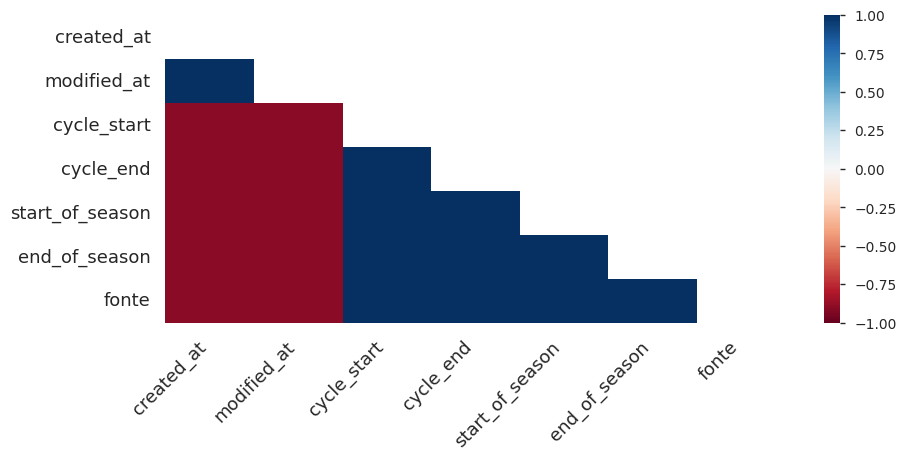

In [39]:
title = "data_report_06_12_2024_cana_data"
config = Settings()
config.vars.cat.words = False  # Desativa a nuvem de palavras
report  = ProfileReport(df=df_copy[list(df_e_object_colums) + ['monitoring_class', 'state', 'period', 'fonte']], 
                        title=title,
                        minimal=False,
                        config=config)

report.to_file(f'{title}.html')

In [41]:
df_number = gdf.select_dtypes(exclude=['float','int', 'datetime'])
df_number

,period,no_till_farming,emergence_date,emergence_sensor,gt_class,senescence_date,senescence_sensor,harvest_date,harvest_sensor,area_ha,...,is_valid,is_valid_cvt,peaks,length_of_season,progress_status,uf,uuid,peak_date,geometry,dataset_part
0,2023/2024,None,2024-01-12,MSI / Sentinel 2,SOYBEAN,2024-03-04,MSI / Sentinel 2,None,None,9.41365563996948,...,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-49.87426 -17.49841, -49.87428...",test
1,2023/2024,None,2024-01-12,MSI / Sentinel 2,SOYBEAN,2024-03-04,MSI / Sentinel 2,None,None,55.58908662027174,...,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-49.87649 -17.50258, -49.88479...",test
2,2023/2024,None,2023-12-06,OLI / Landsat 9,SOYBEAN,2024-02-24,OLI / Landsat 9,2024-03-05,MSI / Sentinel 2,128.7024680578706,...,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-48.5898 -4.8188, -48.58982 -4...",test
3,2023/2024,None,2024-01-17,OLI / Landsat 8,SOYBEAN,2024-03-14,MSI / Sentinel 2,None,None,32.37898634484619,...,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-47.92268 -17.87173, -47.92267...",test
4,2023/2024,None,2024-01-17,OLI / Landsat 8,SOYBEAN,2024-03-13,OLI / Landsat 9,None,None,8.020680603190971,...,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-47.92267 -17.87151, -47.92268...",test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8355,2023/2023,None,2021-12-20,MSI / Sentinel 2,SUGAR_CANE,None,None,2022-11-29,OLI / Landsat 8,None,...,None,None,None,None,ENCERRADO,SP,{02a0f996-ba82-4adc-a417-dd350e73756e},None,"MULTIPOLYGON (((-47.26655 -22.6615, -47.26652 ...",test
8356,2023/2023,None,2021-11-25,MSI / Sentinel 2,SUGAR_CANE,None,None,2022-10-06,MSI / Sentinel 2,None,...,None,None,None,None,ENCERRADO,SP,{822ff516-1caf-4c13-9385-4e4461397674},None,"MULTIPOLYGON (((-47.25891 -22.61851, -47.25884...",test
8357,2023/2023,None,2021-11-05,MSI / Sentinel 2,SUGAR_CANE,None,None,2022-11-25,MSI / Sentinel 2,None,...,None,None,None,None,ENCERRADO,SP,{d15c8fd1-24b8-4643-9543-7d1d99047797},None,"MULTIPOLYGON (((-47.24072 -22.66836, -47.24241...",test
8358,2023/2023,None,2021-09-11,MSI / Sentinel 2,SUGAR_CANE,None,None,2022-11-05,MSI / Sentinel 2,None,...,None,None,None,None,ENCERRADO,SP,{2e14dc3f-9e78-4cd1-96e3-34e821c75683},None,"MULTIPOLYGON (((-47.23388 -22.64052, -47.235 -...",test


# 5. Analysis culture per state

In [ ]:
gdf[gdf['state'].isin(['BA', 'RS', 'MT', 'SP'])].groupby('state').agg({'monitoring_class': 'value_counts'})

In [43]:
gdf[gdf['state'].isin(['BA', 'RS', 'MT', 'SP'])].groupby('state').agg({'monitoring_class':'value_counts'})

monitoring_class
state monitoring_class                  
BA    SOYBEAN                        450
MT    SOYBEAN                       1295
      CORN                            63
RS    SOYBEAN                       1550
SP    SOYBEAN                        820
      CORN                            34

In [ ]:
# df[df['state'].isin(['BA'])].to_file("/agrilearn_app/datasets/geopackages/crop-classification-v3-bahia", driver='GPKG', engine='fiona')
# df[df['state'].isin(['RS'])].to_file("/agrilearn_app/datasets/geopackages/crop-classification-v3-rio-grande-do-sul", driver='GPKG', engine='fiona')
# df[df['state'].isin(['MT'])].to_file("/agrilearn_app/datasets/geopackages/crop-classification-v3-mato-grosso", driver='GPKG', engine='fiona')

In [ ]:
eopath_location